In [44]:
import torch
from torch import nn
from torch import optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from torch.utils.data import Dataset
from torchvision import models
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import PIL
from PIL import Image
import os
import sklearn.metrics
import glob

In [45]:
torch.randn(5).cuda()

tensor([ 0.4441, -0.8120, -0.9349, -0.6505, -1.3115], device='cuda:0')

In [46]:
# Load the MNIST dataset from predefined class and split into train val and test sets
train_data = datasets.MNIST('data', train=True, download = True, transform = transforms.ToTensor())
train, val = random_split(train_data, [55000, 5000])
test = datasets.MNIST('data', train=False, download = True, transform = transforms.ToTensor())
train_loader = DataLoader(train, batch_size = 32)
val_loader = DataLoader(val, batch_size = 32)
test_loader = DataLoader(test, batch_size = 1)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
# class CustomDataset(Dataset):
#     def __init__(self, path):
#         self.imgs_path = path
#         file_list = glob.glob(self.imgs_path+ "*" )
#       # On local machine, glob.glob was returning paths with \ instead of /, so used the command os.path.normpath
#       # file_list = [os.path.normpath(i) for i in glob.glob(self.imgs_path+ "*" )] 
#         #print(file_list)
#         self.data = []
#         for class_path in file_list:
#             class_name = class_path.split("/")[-1]
#             for img_path in glob.glob(class_path + "/*.jpg"):
#                 self.data.append([img_path, class_name])
#         #print(self.data)
#         self.class_map = {"0" : 0, "1": 1, "2" : 2, "3" : 3, "4" : 4, "5" : 5, "6" : 6, "7" : 7, "8" : 8, "9" : 9}
#         self.img_dim = (28, 28)
#     def __len__(self):
#         return len(self.data)
#     def __getitem__(self, idx):
#         img_path, class_name = self.data[idx]
#         img = cv2.imread(img_path)
#         img = cv2.resize(img, self.img_dim)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         img = np.expand_dims(img, axis = 0)
#         img = img/255
#         img_tensor = torch.from_numpy(img)
#         # img_tensor = img_tensor.permute(2, 0, 1)
#         class_id = self.class_map[class_name]
#         # class_id = int(class_name)
#         class_id = torch.tensor([class_id])
#         class_id = torch.squeeze(class_id)
#         return img_tensor.float(), class_id

In [36]:
# # Creating an object from CustomDataset() class and passing the result to DataLoader
# MNIST_dataset = CustomDataset("/content/drive/MyDrive/MNIST Dataset/")
# data_loader = DataLoader(MNIST_dataset, batch_size=32, shuffle=True)
# x, y = next(iter(data_loader))
# print(x.shape)
# print(y.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [47]:
#Define my model
model = nn.Sequential(
    
		nn.Conv2d(in_channels=1, out_channels=20,
			kernel_size=(5, 5)),
		nn.ReLU(),
		nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
		# initialize second set of CONV => RELU => POOL layers
		nn.Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5)),
		nn.ReLU(),
		nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    nn.Flatten(),
		# initialize first (and only) set of FC => RELU layers
		nn.Linear(in_features=800, out_features=500),
		nn.ReLU(),
		# initialize our softmax classifier
		nn.Linear(in_features=500, out_features=10),
		nn.LogSoftmax(dim=1)
).cuda()
#print(model)
print(summary(model, (1, 28, 28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
              ReLU-2           [-1, 20, 24, 24]               0
         MaxPool2d-3           [-1, 20, 12, 12]               0
            Conv2d-4             [-1, 50, 8, 8]          25,050
              ReLU-5             [-1, 50, 8, 8]               0
         MaxPool2d-6             [-1, 50, 4, 4]               0
           Flatten-7                  [-1, 800]               0
            Linear-8                  [-1, 500]         400,500
              ReLU-9                  [-1, 500]               0
           Linear-10                   [-1, 10]           5,010
       LogSoftmax-11                   [-1, 10]               0
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [48]:
# Define my optimizer
optimiser = optim.SGD(model.parameters(), lr =1e-2)

In [49]:
# Define my loss
loss = nn.CrossEntropyLoss()

In [50]:
# Defining training and validation loops
def model_train(model, nb_epochs):

  for epoch in range(nb_epochs):
    losses = list()
    accuracies = list()
    model.train()  #because I use dropout
    for batch in test_loader:
      x,y = batch
      # x = b * 1 * 28 * 28
      b = x.size(0)
    
      #1 Forward
      x = x.cuda()
      l = model(x)

      #2 compute the objective function
      J = loss(l, y.cuda())

      #3 cleaning the gradients
      model.zero_grad()

      #4 accumulate partial derivate of loss wrt params
      J.backward()
      
      #5 step in the opposite direction of the gradient
      optimiser.step()

      losses.append(J.item()) #only taking loss value from J
      accuracies.append(y.eq(l.detach().argmax(dim=1).cpu()).float().mean())

    print(f'Epoch {epoch + 1}', end = ',')
    print(f'training loss: {torch.tensor(losses).mean():.2f}', end = ',')
    print(f'training accuracy: {torch.tensor(accuracies).mean():.2f}')

  #Compute the loss for validation set
    losses = list()
    model.eval()
    for batch in val_loader:
      x,y = batch
      # x = b * 1 * 28 * 28
      b = x.size(0)
      #x = x.view(b, -1)

      #1 Forward
      with torch.no_grad():
        x = x.cuda()
        l = model(x)

      #2 compute the objective function
      J = loss(l, y.cuda())
      losses.append(J.item())
      accuracies.append(y.eq(l.detach().argmax(dim=1).cpu()).float().mean())

    print(f'Epoch {epoch + 1}', end = ',')
    print(f'validation loss: {torch.tensor(losses).mean():.2f}', end = ',')
    print(f'validation accuracy: {torch.tensor(accuracies).mean():.2f}')

In [51]:
# Training the model by calling the model_train function
model_train(model, nb_epochs=5)

Epoch 1,training loss: 0.30,training accuracy: 0.90
Epoch 1,validation loss: 0.25,validation accuracy: 0.90
Epoch 2,training loss: 0.08,training accuracy: 0.98
Epoch 2,validation loss: 0.17,validation accuracy: 0.97
Epoch 3,training loss: 0.05,training accuracy: 0.98
Epoch 3,validation loss: 0.20,validation accuracy: 0.98
Epoch 4,training loss: 0.03,training accuracy: 0.99
Epoch 4,validation loss: 0.11,validation accuracy: 0.99
Epoch 5,training loss: 0.02,training accuracy: 0.99
Epoch 5,validation loss: 0.15,validation accuracy: 0.99


In [52]:
# This function calculates accuracy, precision, recall and F1 score
def calculate_model_metrics(model, Data_loader):

  i =0
  num_correct = 0
  num_samples = 0

  # Creating an iteratible test_loader object that is used to initialize dimensions of pred_old and true_old
  Test_loader_iterator = iter(Data_loader)
  x, y = next(Test_loader_iterator)
  pred_old = np.zeros((y.shape))
  true_old = np.zeros((y.shape))

  # Generate image with predicted label 
  model.eval()
  with torch.no_grad():
    for x, y in Data_loader:

      #print(x.shape)
      x=x.cuda()
      y=y.cuda()
      scores = model(x)
      _, predictions = scores.max(1)  
      x=x.cpu()
      y=y.cpu()
      predictions = predictions.cpu()

      num_correct += (predictions == y).sum()
      num_samples += predictions.size(0)

      #converting y and prediction to array
      if (i==0):
        true = np.array(y)
        pred = np.array(predictions)
      else:
        true= np.append(np.array(y),true_old)
        pred= np.append(np.array(predictions), pred_old)
      true_old = true
      pred_old = pred
      i = i+1
  accuracy = float(num_correct)*100/float(num_samples)
  precision = sklearn.metrics.precision_score(y_true=true, y_pred=pred, average = 'weighted')
  recall = sklearn.metrics.recall_score(y_true= true, y_pred=pred, average='weighted')
  f1_score = sklearn.metrics.f1_score(y_true=true, y_pred=pred, average='weighted')

  return accuracy, precision, recall, f1_score

In [53]:
# Print accuracy, precision, recall and F1 score on the resultant trained model
accuracy, precision, recall, f1_score = calculate_model_metrics(model, test_loader)
print(f'The accuracy of our model is {accuracy:.2f}')
print(f'The precision of our model is: {precision:.2f}')
print(f'The recall of our model is: {recall:.2f}')
print(f'The F1 score of our model is: {f1_score:.2f}')

The accuracy of our model is 98.61
The precision of our model is: 0.99
The recall of our model is: 0.99
The F1 score of our model is: 0.99


In [58]:
# Code to save images to folders where first folder is the ground truth class and second folder is the predicted class
def save_images_to_folder(Data_loader):

  # Create new folders as per the class labels
  import os
  l1 = ["0","1", "2", "3", "4", "5", "6", "7", "8", "9"]
  l2 = ["0","1", "2", "3", "4", "5", "6", "7", "8", "9"]
  for path1 in l1:
    dir = os.path.join("/content",path1)
    if not os.path.exists(dir):
      os.mkdir(dir)
    for path2 in l2:
        dir = os.path.join("/content",path1,path2)
        if not os.path.exists(dir):
          os.mkdir(dir)


  # Run model to get predictions
  i = np.zeros((10))
  j = np.zeros((10))

  model.eval()
  for x, y in Data_loader:
    with torch.no_grad():
      x=x.cuda()
      y=y.cuda()
      scores = model(x)
      _, predictions = scores.max(1)           #get the predicted label with max value

      x=x.cpu()
      y=y.cpu()
      predictions = predictions.cpu()

      im_array = np.array(x[0][0]*255, dtype=np.uint8)  #convert output tensor x to array
      im = PIL.Image.fromarray(im_array)          #convert numpy array to image

      # Converting y and prediction to string to be used later for folders
      true=np.array2string(np.array(y[0]))  
      pred=np.array2string(np.array(predictions[0]))

      # Saving images to the desired path
      if (predictions == y):
        i[y]=i[y]+1                          # To be used to name the images
        dir = os.path.join("/content", true, true) # Set the path where image needs to be saved
        im.save(dir+"/"+str(i[y])+".jpg")    # Save image to path

      else:
        j[predictions]+=1
        dir = os.path.join("/content", true, pred) 
        im.save(dir+"/"+str(i[y])+".jpg")

In [59]:
# Save images to folder where first folder is true class and second folder is predicted class
save_images_to_folder(test_loader)

In [56]:
# Create an iteratable object that will be iterated through by calling the below function
Test_loader_iterator = iter(test_loader)

# Generate image with predicted label 
def img_with_label(Data_loader_iterator):
  x, y = next(Data_loader_iterator)
  x=x.cuda()
  y=y.cuda()
  scores = model(x)
  _, predictions = scores.max(1)  
  x=x.cpu()
  y=y.cpu()
  predictions = predictions.cpu()
  tensor = np.array(x[0][0]*255, dtype=np.uint8)  #convert input image tensor x to array
  im = PIL.Image.fromarray(tensor)          #convert numpy array to image

  # Converting y and prediction to string to be used later for folders
  true=np.array2string(np.array(y[0]))  
  pred=np.array2string(np.array(predictions[0]))
  plt.title("the predicated class label is: " + pred)
  plt.imshow(im,)

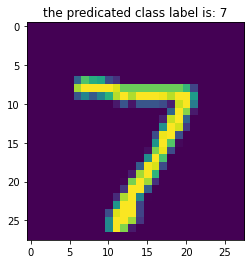

In [57]:
# Print an image with its pridicted label
img_with_label(Test_loader_iterator)